# Tutorial notebook #1
This notebook shows how to carry out noise scaling using a sparse pauli-lindblad model on an arbitrary circuit. This is an object-oriented framework, and encapsulation is implemented to make this procedure possible with different levels of abstraction. This is the most abstracted version.

In [24]:
from qiskit import QuantumCircuit, Aer
from qiskit.providers.fake_provider import FakeVigoV2
from matplotlib import pyplot as plt
import sys

sys.path.append("../pauli_lindblad_per")
from tomography.experiment import SparsePauliTomographyExperiment as tomography

plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = [20, 6]

## The Backend
Currently, only the Qiskit backend interface is implemented, but hopefully the utilization is sufficiently generic to be easily translated to other platforms. Initialze a `BackendV2` object:

In [2]:
backend = FakeVigoV2()

## The Quantum Circuit (or many!)

The implemented interface currently has support for `QuantumCircuit` objects. Construct a circuit consisting of single qubit gates and self-adjoint clifford gates in any order. Any number of circuits can be benchmarked at once. Circuits with the same Clifford gates repeated many times will not take longer to benchmark, because these layers will have the same noise profile. There are a few requirements:
- The circuit must end with a self-adjoint Clifford layer. Measurement of expectation values is implemented automatically, so basis change gates are not necessary. This is done to preserve the noise profile of the dressed layers.
- The entangling gates should be supported on the hardware, otherwise the behavior may be undefined when remapped by the compiler.
- Measurements are handled but will not have any affect on the procedure.

In [3]:
qc = QuantumCircuit(2)
qc.cx(0,1)
qc.draw()

q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘

## The Executor

The experiment makes use of an executor function which takes in a list of circuits in the native implementation (Qiskit / PyQuil) and returns the results. There are two conditions on the formatting of this method:
- The output array must be in the same order as the input circuits, so that the results correspond to the circuits in the input array
- The output must be in the format of a dictionary, where the keys are strings representing binary results in the computational basis, and the values represent frequencies.

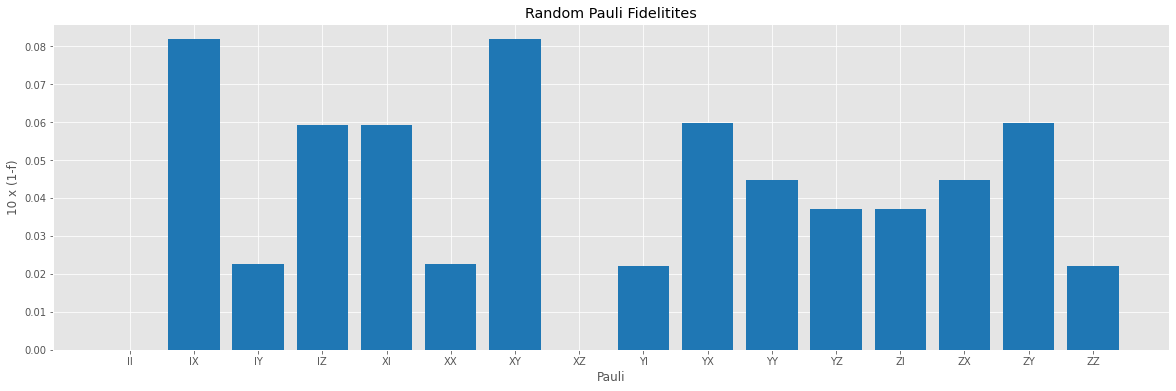

In [4]:
from qiskit.quantum_info import pauli_basis, Pauli, PTM
from qiskit.providers.aer.noise import NoiseModel, pauli_error
from random import random, choices

num = 4  #number of errors
errorops = choices(pauli_basis(2, pauli_list = True), k=num) #choose random pauli errors
errorprobs = [random()*.1/num for op in errorops] #assign random probabilities
#create normalized error model
twoqubit_error = pauli_error([(op, p) for op,p in zip(errorops, errorprobs)]+[(Pauli("II"), 1-sum(errorprobs))])
noise_model = NoiseModel()
#add error model to two-qubit gates.
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])

real_errors = {}
transfer_matrix = PTM(twoqubit_error.to_quantumchannel()).data
for i,pauli in enumerate(pauli_basis(2, pauli_list = True)):
    real_errors[pauli] = transfer_matrix[i][i]
    plt.bar(pauli.to_label(), (1-transfer_matrix[i][i]).real, color="tab:blue")

plt.title("Random Pauli Fidelitites")
plt.xlabel("Pauli")
plt.ylabel("10 x (1-f)")


def executor(circuits):
    return Aer.get_backend("qasm_simulator").run(circuits, noise_model = noise_model, shots = 500).result().get_counts()

## Construct the tomography experiment
The parameters of a tomography experiment are
- circuits : a list of circuits to be benchmarked
- inst_map : a mapping from virtual qubits to physical qubits. This can be used to include which qubits are considered in the benchmark.
- backend : a BackendV2 object

In [5]:
experiment = tomography(circuits = [qc], inst_map = [0,1], backend = backend)

## Generate the experiment
Constructing the experiment sets up parameters that will be constant for any choice of parameters. This generates all of the required circuits for the benchmarking procedure. The parameters are
- samples : The number of samples to take from the twirl on the SPAM-free pairwise measurements. The measurement will improve with the samples from the twirl.
- single_samples : A number of degeneracy-lifting measurements need to be made. These cannot be fit to an exponential, so the noise in a single measurement determines the noise in the fidelity prediction. For this reason, it may be desirable to set this number higher than `single_samples`.
- depths : The depths to use for the exponential fidelity fits. At least three must be chosen to get the covariance associated with the fit.

In future versions, the generate method could be encapsulated to make this part more seamless. They are kept separate here to match the behavior of the underlying classes.


In [6]:
experiment.generate(samples = 50, single_samples = 200, depths = [2,4,6,16])

## Run!
Pass the executor function to `experiment.run` and await the results

In [7]:
experiment.run(executor)

## Analysis
Once the run data is collected, the experiment class is no longer strictly necessary. At this point, the results can be saved for later processing. To reflect this behavior while centralizing the functionality to the SparsePauliTomographyExperiment class, the `analyze` method is kept separate. This is also in line with the Qiskit Experiments framework, which similarly separates the experimental and analysis procedure.

The output of the analysis procedure is an object called `NoiseDataFrame`, which is a data structure storing `spam` coefficients and a dictionary with the results of the tomography experiment as values and circuit layers as keys.

In [8]:
noisedataframe = experiment.analyze()

## Run PER
Now that the data has been collected, the PER procedure can be started. This can be constructed on its own by passing a list of circuits, an `inst_map`, a `NoiseDataFrame`, and a `backend` to the `PERExperiment` class. The `SparsePauliTomography` class contains a routine to construct this class automatically.

Input
- Circuits : A list of circuits in the native language. A single PER experiment can be used to run many circuits, which is useful for simulation applications.


In [ ]:
perexp = experiment.create_per_experiment([qc])

## Generate circuits
The PER section of the framework mirrors the benchmarking section: Experimental parameters -> circuit generation -> running -> analysis -> condense/plot/use results. THe inputs to the PER generation procedure are the following:
- expectations : Pauli expectations to measure after running the circuits. The algorithm will automatically determine the minimal set of measurements that need to be made to reconstruct these expectations.
- samples : The number of times to sample from the noise inverse. A higher number of samples will generally improve the performance of the estimator. In future versions, this will be calculated automatically for different layers to achieve a constant precision over different overheads.
- Noise strengths : So far the iteration of PER that is implemented is noise-scaling and virtual-zne. More than three noise strengths should be chosen to perform the fit, and these can be any positive real number.

In [ ]:
perexp.generate(expectations = ["IZI", "ZII","IIZ"], samples = 100, noise_strengths = [0,1,2])

## Run!

In [ ]:
perexp.run(executor)

## Analyze
This returns a list of `PERRun` objects holding data corresponding to a single circuit and different expectation values and noise parameters.

In [ ]:
circuit_results = perexp.analyze()

NameError: name 'perexp' is not defined

## Plot results
The result of the zero-noise extrapolation is the y-intercept of the exponential fit. The goodness of this fit can be visualized by using the plot method. The extrapolated expectation can be obtained by calling the `get_result` method with a string representation of the desired Pauli expectation, and then using the `expectation` instance varaiable of the resulting `PERData` object.

<AxesSubplot:>

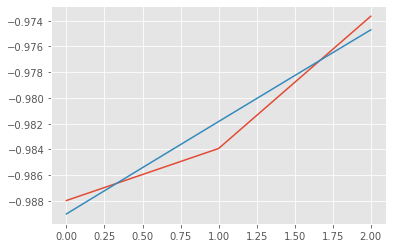

In [ ]:
circuit_results[0].get_result("IZI").plot()

## Plot Benchmark Data
The benchmarking aspect of this framework is less interesting because it has been implemented elsewhere, but this package seeks to make it easy to carry out and visualize results. Here are some of the graphing utilites:
- graph : Plot the fits to the Pauli pair fidelities. 
- plot_infidelities : This can show which of the link or single qubits experience the most noise during an algorithm
- plot_coeffs : This shows the terms in the generator of the noise affecting any link or single qubit. This can be used to view the dominant type of noise experience by the qubit or link.

The `analysis.layer_data()` function returns `LayerNoiseData` objects so that the noise corresponding to each of the layers can be viewed individually. A strategy for displaying the layer which corresponds to each of these object should be developed, because the order may not be the same order they appear in the circuit.

In [9]:
layer1,= experiment.analysis.layer_data()

The experiment was carried out on a fake backend, and the exponential decays show that the twirl appropriately converts the noise channel, which is a simulated combination of amplitude damping and dephasing, into a Pauli channel.

<AxesSubplot:>

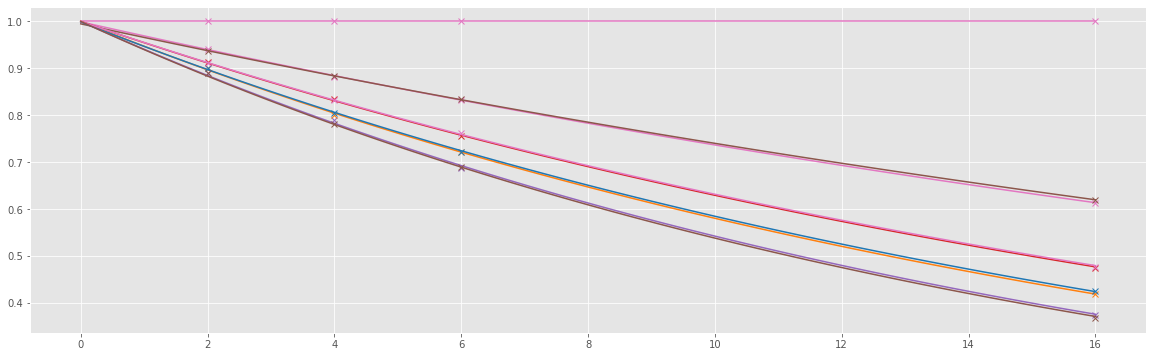

In [10]:
layer1.graph((0,1))

<AxesSubplot:>

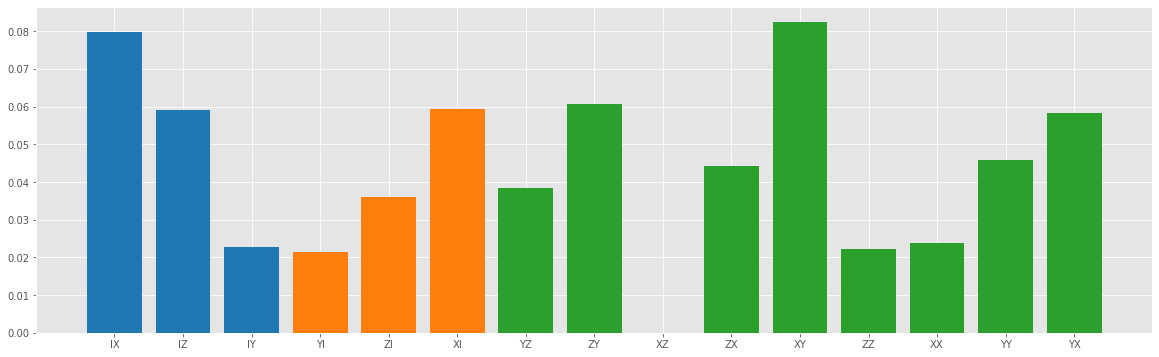

In [11]:
layer1.plot_infidelitites((0,),(1,),(0,1))

In [12]:
terms = list([t.to_label() for t in layer1._term_data.keys()])
fidelities = list([1-dat.fidelity for dat in layer1._term_data.values()])

In [13]:
data = layer1._term_data
from primitives.pauli import QiskitPauli

In [14]:
data[QiskitPauli("XX")].fidelity

0.9763104196769605

In [15]:
[real_errors[Pauli(lab)] for lab in terms]

[(0.9628809506892599+0j),
 (0.9402359158957481+0j),
 (0.9181864782260594+0j),
 (1+0j),
 (0.9408315130195712+0j),
 (0.9779505623303113+0j),
 (0.9553055275367994+0j),
 (0.9181864782260594+0j),
 (0.9779505623303113+0j),
 (0.9773549652064881+0j),
 (0.9553055275367994+0j),
 (0.9402359158957481+0j),
 (0.9628809506892599+0j),
 (0.9773549652064881+0j),
 (0.9408315130195712+0j)]

/home/ben/.local/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


([<matplotlib.axis.XTick at 0x7f6a29d59f00>,
 [Text(0, 0, 'YZ'),
  Text(1, 0, 'ZY'),
  Text(2, 0, 'IX'),
  Text(3, 0, 'XZ'),
  Text(4, 0, 'IZ'),
  Text(5, 0, 'YI'),
  Text(6, 0, 'ZX'),
  Text(7, 0, 'XY'),
  Text(8, 0, 'ZZ'),
  Text(9, 0, 'XX'),
  Text(10, 0, 'YY'),
  Text(11, 0, 'YX'),
  Text(12, 0, 'ZI'),
  Text(13, 0, 'IY'),
  Text(14, 0, 'XI')])

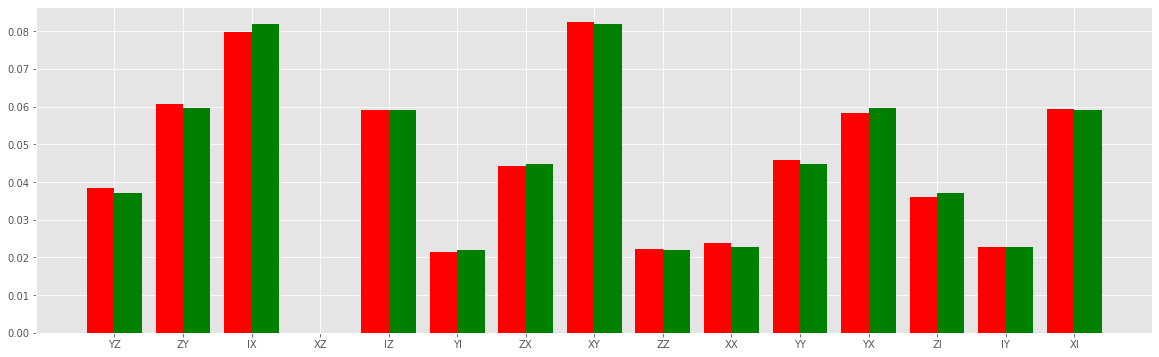

In [16]:
import numpy as np
ax = np.arange(0,len(terms))
plt.bar(ax+.2, [1-real_errors[Pauli(lab)] for lab in terms],.4, color='g')
plt.bar(ax-.2, fidelities, .4,color = 'r')
plt.xticks(ax, terms)

In [17]:
[(term.pauli.to_label(),term.pair.to_label()) for term in data.values() if term.single_fidelity is not None]

[('IX', 'XX'),
 ('YI', 'YZ'),
 ('ZX', 'YY'),
 ('YX', 'ZY'),
 ('ZI', 'ZZ'),
 ('IY', 'XY')]

([<matplotlib.axis.XTick at 0x7f6a2b4be650>,
 [Text(0, 0, "('YZ', 'YI')"),
  Text(1, 0, "('ZY', 'YX')"),
  Text(2, 0, "('IX', 'XX')"),
  Text(3, 0, "('XZ', 'XZ')"),
  Text(4, 0, "('IZ', 'IZ')"),
  Text(5, 0, "('YI', 'YZ')"),
  Text(6, 0, "('ZX', 'YY')"),
  Text(7, 0, "('XY', 'IY')"),
  Text(8, 0, "('ZZ', 'ZI')"),
  Text(9, 0, "('XX', 'IX')"),
  Text(10, 0, "('YY', 'ZX')"),
  Text(11, 0, "('YX', 'ZY')"),
  Text(12, 0, "('ZI', 'ZZ')"),
  Text(13, 0, "('IY', 'XY')"),
  Text(14, 0, "('XI', 'XI')")])

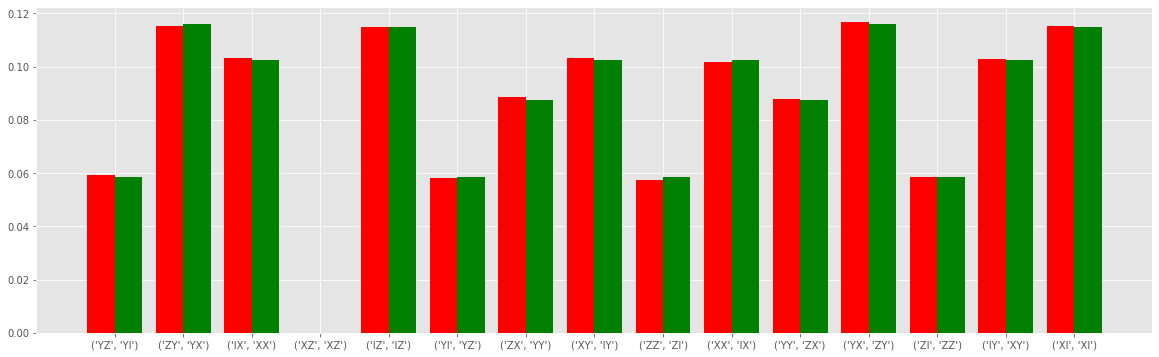

In [18]:
import numpy as np
ax = np.arange(0,len(terms))
terms = list([(t.pauli.to_label(),t.pair.to_label()) for t in layer1._term_data.values()])
fidelities = list([1-dat.pair_fidelity**2 for dat in layer1._term_data.values()])
plt.bar(ax+.2, [(1-real_errors[Pauli(lab)]*real_errors[Pauli(pair)]) for lab,pair in terms],.4, color='g')
plt.bar(ax-.2, fidelities, .4,color = 'r')
plt.xticks(ax, terms)

([<matplotlib.axis.XTick at 0x7f6a2a338130>,
 [Text(0, 0, 'IX'),
  Text(1, 0, 'YI'),
  Text(2, 0, 'ZX'),
  Text(3, 0, 'YX'),
  Text(4, 0, 'ZI'),
  Text(5, 0, 'IY')])

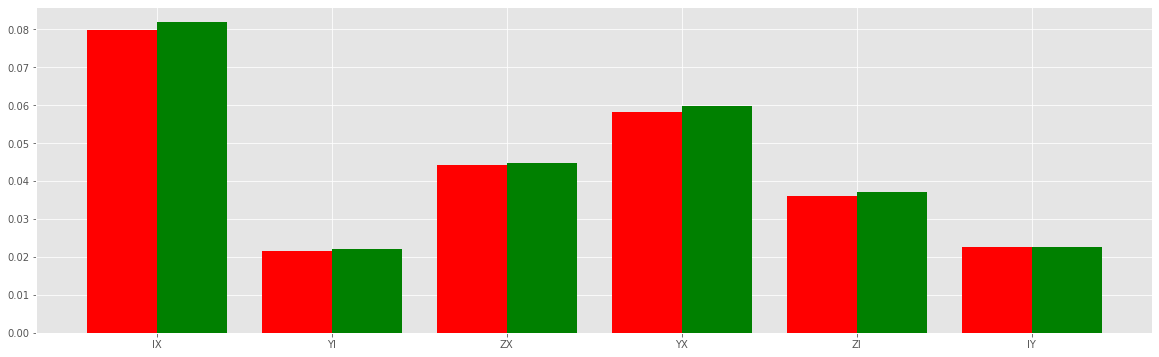

In [20]:
import numpy as np
ax = np.arange(0,len(terms))
terms = list([t for t in layer1._term_data.values() if t.single_fidelity])
fidelities = list([1-t.single_fidelity for t in terms])
plt.bar(ax+.2, [1-real_errors[t.pauli.pauli] for t in terms],.4, color='g')
plt.bar(ax-.2, fidelities, .4,color = 'r')
plt.xticks(ax, [t.pauli.to_label() for t in terms])

In [22]:
insts = [inst for inst in layer1.layer.instances if inst.meas_basis == QiskitPauli("IY")]

In [23]:
1-sum([inst.get_expectation(QiskitPauli("IY")) for inst in insts])/len(insts)

0.02900000000000036

In [24]:
1-real_errors[Pauli("IY")]

(0.030015931203723367+0j)

In [26]:
layer1._term_data[QiskitPauli("IY")]._single_count

600

In [28]:
insts[0]._circ.qc.draw()

global phase: 5π/4
               ┌─────────┐ ┌────┐                 ░ ┌────────┐┌────┐┌─────────┐»
      q_0 -> 0 ┤ Rz(π/2) ├─┤ √X ├─────────────■───░─┤ Rz(-π) ├┤ √X ├┤ Rz(π/2) ├»
               ├─────────┴┐├────┤┌─────────┐┌─┴─┐ ░ └─┬───┬──┘└────┘└─────────┘»
      q_1 -> 1 ┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/2) ├┤ X ├─░───┤ X ├────────────────────»
               └──────────┘└────┘└─────────┘└───┘ ░   └───┘                    »
ancilla_0 -> 2 ────────────────────────────────────────────────────────────────»
                                                                               »
ancilla_1 -> 3 ────────────────────────────────────────────────────────────────»
                                                                               »
ancilla_2 -> 4 ────────────────────────────────────────────────────────────────»
                                                                               »
       meas: 2/════════════════════════════════════════════════════════════════»
                                                                               »
«                ░ ┌─┐   
«      q_0 -> 0 ─░─┤M├───
«                ░ └╥┘┌─┐
«      q_1 -> 1 ─░──╫─┤M├
«                ░  ║ └╥┘
«ancilla_0 -> 2 ────╫──╫─
«                   ║  ║ 
«ancilla_1 -> 3 ────╫──╫─
«                   ║  ║ 
«ancilla_2 -> 4 ────╫──╫─
«                   ║  ║ 
«       meas: 2/════╩══╩═
«                   0  1

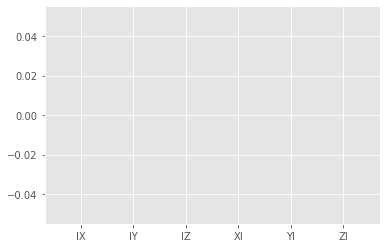

In [ ]:
layer1.plot_coeffs((0,),(1,))

In [22]:
model_terms = layer1._term_data

/home/ben/anaconda3/envs/qiskit_env/lib/python3.10/site-packages/scipy/optimize/_nnls.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
  x, rnorm, mode = __nnls.nnls(A, m, n, b, w, zz, index, maxiter)


Text(0, 0.5, 'Coefficient')

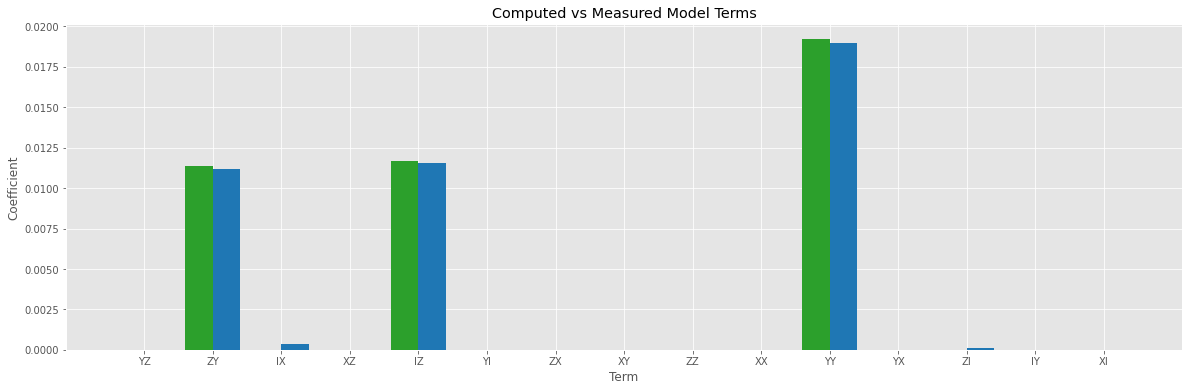

In [23]:
from scipy.optimize import nnls

f1 = []
f2 = []
fidelities = []
for key in model_terms.values():
    f1.append(key.pauli)
    fidelities.append(key.fidelity)
    if key.single_fidelity:
        f2.append(key.pair)
    else:
        f2.append(key.pauli)

sprod = lambda a,b: int(not a.commutes(b))
m1 = [[sprod(a,b) for a in model_terms] for b in f1]
m2 = [[sprod(a,b) for a in model_terms] for b in f2]

real_coeffs, real_rnorm = nnls(m1, -.5*np.log([real_errors[term.pauli] for term in f1]))
coeffs = dict(list(noisedataframe.noisemodels.values())[0].coeffs)
meas_coeffs = [coeffs[term] for term in f1]

ax = np.arange(len(model_terms))
plt.bar(ax+.2, meas_coeffs, .4, color='tab:blue')
plt.bar(ax-.2, real_coeffs, .4, color='tab:green')
plt.xticks(ax, [t.to_label() for t in model_terms]);
plt.title("Computed vs Measured Model Terms")
plt.xlabel("Term")
plt.ylabel("Coefficient")